In [1]:
import keras
keras.__version__

'2.8.0'

# Deep Dream

This notebook contains the code samples found in Chapter 8, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

[...]

## Implementing Deep Dream in Keras


We will start from a convnet pre-trained on ImageNet. In Keras, we have many such convnets available: VGG16, VGG19, Xception, ResNet50... 
albeit the same process is doable with any of these, your convnet of choice will naturally affect your visualizations, since different 
convnet architectures result in different learned features. The convnet used in the original Deep Dream release was an Inception model, and 
in practice Inception is known to produce very nice-looking Deep Dreams, so we will use the InceptionV3 model that comes with Keras.


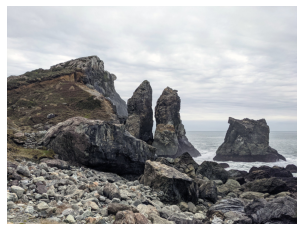

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [3]:
from keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)


Next, we compute the "loss", the quantity that we will seek to maximize during the gradient ascent process. In Chapter 5, for filter 
visualization, we were trying to maximize the value of a specific filter in a specific layer. Here we will simultaneously maximize the 
activation of all filters in a number of layers. Specifically, we will maximize a weighted sum of the L2 norm of the activations of a 
set of high-level layers. The exact set of layers we pick (as well as their contribution to the final loss) has a large influence on the 
visuals that we will be able to produce, so we want to make these parameters easily configurable. Lower layers result in 
geometric patterns, while higher layers result in visuals in which you can recognize some classes from ImageNet (e.g. birds or dogs).
We'll start from a somewhat arbitrary configuration involving four layers -- 
but you will definitely want to explore many different configurations later on:

In [4]:
# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

The Deep Dream Loss

In [5]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

**The DeepDream gradient ascent process**

In [6]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image


Finally, here is the actual Deep Dream algorithm.

First, we define a list of "scales" (also called "octaves") at which we will process the images. Each successive scale is larger than 
previous one by a factor 1.4 (i.e. 40% larger): we start by processing a small image and we increasingly upscale it:

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)


Then, for each successive scale, from the smallest to the largest, we run gradient ascent to maximize the loss we have previously defined, 
at that scale. After each gradient ascent run, we upscale the resulting image by 40%.

To avoid losing a lot of image detail after each successive upscaling (resulting in increasingly blurry or pixelated images), we leverage a 
simple trick: after each upscaling, we reinject the lost details back into the image, which is possible since we know what the original 
image should look like at the larger scale. Given a small image S and a larger image size L, we can compute the difference between the 
original image (assumed larger than L) resized to size L and the original resized to size S -- this difference quantifies the details lost 
when going from S to L.

The code above below leverages the following straightforward auxiliary Numpy functions, which all do just as their name suggests. They 
require to have SciPy installed.

In [7]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

**Image processing utilities**

In [8]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [9]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.17
... Loss value at step 5: 2.49
... Loss value at step 6: 2.84
... Loss value at step 7: 3.20
... Loss value at step 8: 3.55
... Loss value at step 9: 3.93
... Loss value at step 10: 4.27
... Loss value at step 11: 4.63
... Loss value at step 12: 4.98
... Loss value at step 13: 5.31
... Loss value at step 14: 5.69
... Loss value at step 15: 6.07
... Loss value at step 16: 6.39
... Loss value at step 17: 6.79
... Loss value at step 18: 7.07
... Loss value at step 19: 7.42
... Loss value at step 20: 7.73
... Loss value at step 21: 8.04
... Loss value at step 22: 8.38
... Loss value at step 23: 8.65
... Loss value at step 24: 8.92
... Loss value at step 25: 9.24
... Loss value at step 26: 9.53
... Loss value at step 27: 9.73
... Loss value at step 28: 10.04
... Loss value at step 29: 10.27
Proces

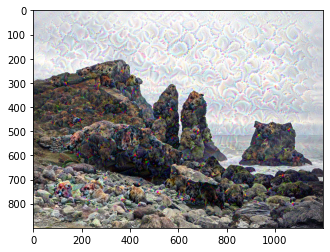

In [10]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()